# 7 Generative AI



### 00 General Setup

We provide you with the data loading framework, training, and validation code. 
If you are interested in how to streamline this process, feel free to look at <a href="https://lightning.ai/docs/pytorch/stable/">Pytorch Lightning</a>.


In [1]:
# Please install this by running this cell or use the requirements.txt again
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as TT
from torchsummary import summary

import numpy as np 
import matplotlib.pyplot as plt

from vll.train.VAE_utils import train, validate, plot_training
from typing import List, Optional


# Change this if you have memory problems
batch_size = 64
test_batch_size = 1000

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

print('Running on CUDA' if use_cuda else 'Running on CPU')

Running on CUDA


## 01 Setup AE (6P)

In this subtask, you are asked to set up a basic Auto Encoder (AE). This will establish the basics for the following exercises. 

We will implement a Convolutional AE since we are working with image data.
Each Layer of the AE Encoder should consist of a 2D Convolution with a kernel size of 3 and a stride of 2 (padding is set to 1). This means the image resolution will be reduced by two after each layer. 
A 2D BatchNorm and a LeakyReLU follow the 2D Convolution. 

The channels should be transformed in the following way: [input, 32, 64, 128, 256] 

For the Decoder, we use 2D Transposed Convolutions (padding and output_padding ist again 1) instead of Convolutions. We mirror the following channels: [256, 128, 64, 32]. 
For the final layer of the Decoder, we add after a Leaky ReLU a resizing (TT.Resize((28, 28))) followed by another 2D Convolution, which reduces the Channels to the number of output Channels (in our case 1) and a stride of 1 as well as kernel size of 1 (padding to 0). 
A tanh activation follows this. 


![alt text](data/AE_CompVisionEx7.png "AE Structure")

In [3]:
class Vanilla_AE(nn.Module):
    '''
    Implementation of a Simple AE
    -----------------------------
    in_channels: Number of input Channels (in our case number of image Channels)
    latent_dim: determines the size of the latent dimension
    input_size: np.array of H x W of input images 
    hidden_dim: List of channel sizes of the Encoder Decoder layers
    

    -----------------------------
    Will setup a simple AE with a encode, decode, forward, loss_function, sample and generate function
    '''

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 input_size: np.ndarray,
                 hidden_dims: List = None,
                 **kwargs) -> None:
    
        super(Vanilla_AE, self).__init__()
        
        self.input_size = input_size
        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            self.hidden_dims = [32, 64, 128, 256]
        else: 
            self.hidden_dims = hidden_dims

        # TODO: Build Encoder
        # Tipp: You can use a loop over the hidden dims in combination with a nn.Sequential
        current_channels = in_channels
        for h_dim in self.hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(current_channels, h_dim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            current_channels = h_dim

        # TODO: Save complete Encoder Sequential as self.encoder
        self.encoder = nn.Sequential(*modules)

        # We basically calculate the image resolution here 
        # Since we use a fixed latent dim we need to calculate what the latent dim will be with our 
        # fixed image size. Since we always use stride=2, with each block we reduce the image resolution
        # by 2. 
        # Because // always rounds down, while nn.Conv2D will round up we add 2 - 1 to get the rounded up 
        # result.
        self.block_dimension = self.input_size 
        for i in range(len(self.hidden_dims)): 
            self.block_dimension = (self.block_dimension + 2 - 1) // 2

        # This is used for the VAE later on 
        # For the AE we just use the fully_connecte mu predictor (fc_mu)
        self.fc_mu = nn.Linear(self.hidden_dims[-1] * self.block_dimension[0] * self.block_dimension[1], latent_dim)
        self.fc_var = nn.Linear(self.hidden_dims[-1] * self.block_dimension[0] * self.block_dimension[1], latent_dim)


        # Build Decoder
        # Since the upsample results in images of 32 by 32 we need a resize operation in the final_layer
        # Remember to do this
        # TODO: Implement your decoder
        # You can do this similar to the encoder
        modules = [nn.Sequential(
                    nn.Linear(latent_dim, self.hidden_dims[-1] * self.block_dimension[0] * self.block_dimension[1]),
                    nn.Unflatten(1, (self.hidden_dims[-1], int(self.block_dimension[0]), int(self.block_dimension[1]))))]
        # for h_dim in self.hidden_dims[::-1]:
        for h_dim in [128, 64, 32, 32]:
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(current_channels, h_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            current_channels = h_dim


        # TODO: Save complete Encoder Sequential as self.encoder
        self.decoder = nn.Sequential(*modules)

        # TODO: Set up Final Layer of Transposed Convolution and Resizing
        self.final_layer = nn.Sequential(
            nn.Upsample(size=(28, 28)),
            nn.Conv2d(self.hidden_dims[0], in_channels, kernel_size=1, stride=1, padding=0),
            nn.Tanh()
        )


    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        # TODO: Implement the encoder forward
        # Use the self.fc_mu as well to predict the latent directly
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        latent = self.fc_mu(result)
        return latent

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D] (D is the latent Dimension)
        :return: (Tensor) [B x C x H x W]
        """
        # TODO: Implement the decoder forward
        result = self.decoder(z)
        result = self.final_layer(result)
        return result

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        ''' 
        Implemets the complete forward pass. 
        '''
        # TODO: Implemnt the combination of Encoder and Decoder
        # The outputs have to be in a list in the exact order given below
        z = self.encode(input)
        reconstruction = self.decode(z)
        return [reconstruction, input, z]

    def loss_function(self,
                      prediction: List[Tensor], # This is what you return in forward !
                      target: Tensor, 
                      **kwargs) -> dict:
        """
        Computes the AE loss function.
        AE: Just simple MSE_loss
        -----------------------------
        prediction: output of forward call 
        target: target image
        param kwargs: optional kwargs
        ------------------------------

        return: Loss
        """
        # TODO: Implement the AE loss function
        loss = F.mse_loss(prediction[0], target)
        return loss


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
       BatchNorm2d-2           [-1, 32, 14, 14]              64
         LeakyReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          18,496
       BatchNorm2d-5             [-1, 64, 7, 7]             128
         LeakyReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 2, 2]         295,168
      BatchNorm2d-11            [-1, 256, 2, 2]             512
        LeakyReLU-12            [-1, 256, 2, 2]               0
           Linear-13                    [-1, 2]           2,050
           Linear-14                 [-

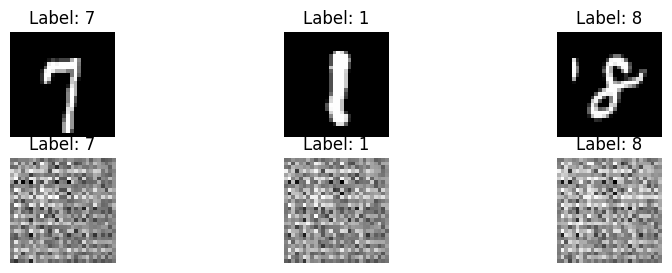

In [4]:
# Test your implementation
# You should see the original MNIST images and 2 noisy images below (since the AE is not trained yet)

AE_model = Vanilla_AE(in_channels=1, latent_dim=2, input_size=np.array([28, 28]), hidden_dims=[32, 64, 128, 256])

summary(AE_model, input_size=(1, 28, 28), device='cpu')


data_instance = iter(train_loader)
images, labels = next(data_instance)


predicted_img, input, z = AE_model(images)

fig, axes = plt.subplots(2, 3, figsize=(10, 3))
for i in range(3):
    image = images[i].numpy().squeeze()  # Bild in numpy-Array umwandeln und Kanal dimension entfernen
    axes[0][i].imshow(image, cmap='gray')
    axes[0][i].set_title(f'Label: {labels[i].item()}')
    axes[0][i].axis('off')
    # Same for prediction
    pred_img = predicted_img[i].detach().numpy().squeeze()
    axes[1][i].imshow(pred_img, cmap='gray')
    axes[1][i].set_title(f'Label: {labels[i].item()}')
    axes[1][i].axis('off')
plt.show()


/home/jesse/miniconda3/envs/3dcv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



Test set: Average loss: 0.00101597

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.17347538
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.57145989
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.58940887
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.60818315
Train Epoch: 1 	 Average: 0.00902821

Test set: Average loss: 0.00055428

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.54038066
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.55494136
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.54812497
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.54144591
Train Epoch: 2 	 Average: 0.00848434

Test set: Average loss: 0.00054813



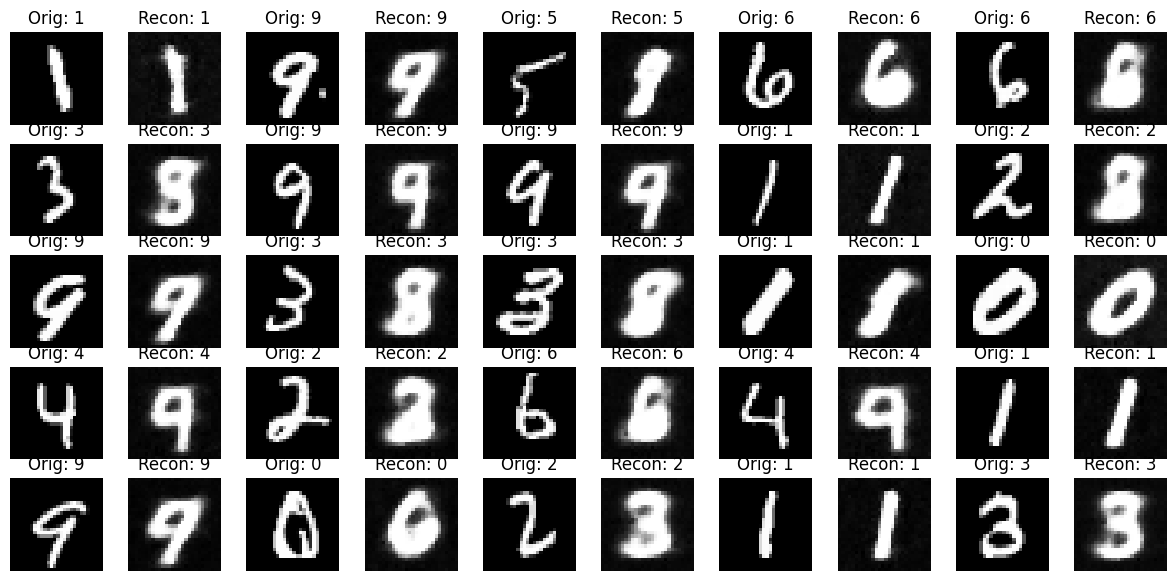

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.54189050
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.54666388
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.54827648
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.53531849
Train Epoch: 3 	 Average: 0.00831225


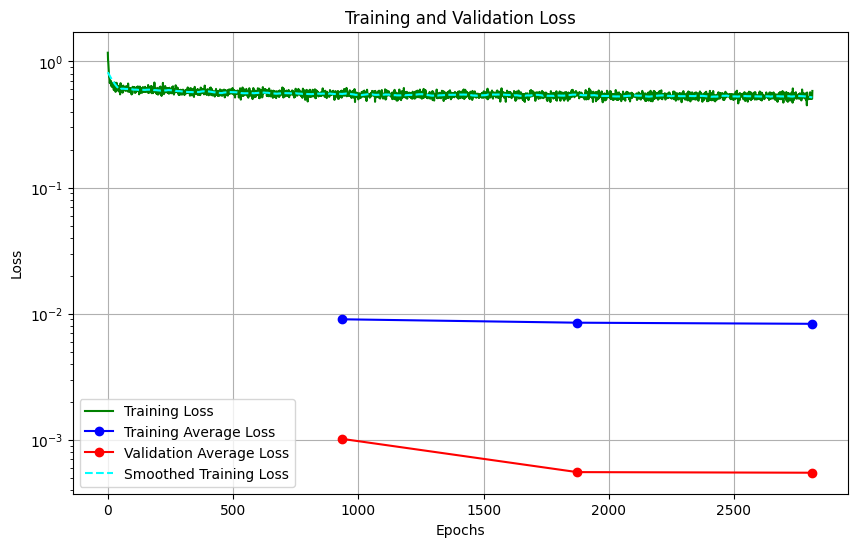

In [5]:
# Trainig 
epochs = 3
lr = .3
log_interval = 250

optimizer = optim.Adadelta(AE_model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)


tr_loss = []
tr_loss_step = []
test_loss = []
if use_cuda: 
    AE_model = AE_model.cuda()
for epoch in range(1, epochs + 1):
    # Validate 
    if epoch % 3 == 0:
        validate(model=AE_model, use_cuda=use_cuda, test_loader=test_loader, test_loss=test_loss, plot=True)
    else:
        validate(model=AE_model, use_cuda=use_cuda, test_loader=test_loader, test_loss=test_loss, plot=False)
    # train one epoch
    train_loss_tmp = []
    train(model=AE_model, use_cuda=use_cuda, train_loader=train_loader, optimizer=optimizer,
          epoch=epoch, log_interval=log_interval, tr_loss=train_loss_tmp)
    for i in range(len(train_loss_tmp)):
        tr_loss_step.append(train_loss_tmp[i])
    tr_loss.append(np.sum(train_loss_tmp).item() / len(train_loader.dataset))
    print(f'Train Epoch: {epoch} \t Average: {tr_loss[-1]:.8f}')

    scheduler.step(test_loss[-1])

plot_training(tr_loss_step, tr_loss, test_loss, epochs, train_loader, batch_size)

    

## 02 VAE (2P)

The AE is a self-supervised network often used in outlier detection. However, since we do not know the AE's latent state, we can not generate new samples from it. 

We visualised the latent of your trained AE with the following plot. You should see some Clusters; however, many of the individual classes overlap heavily or are not well separated.

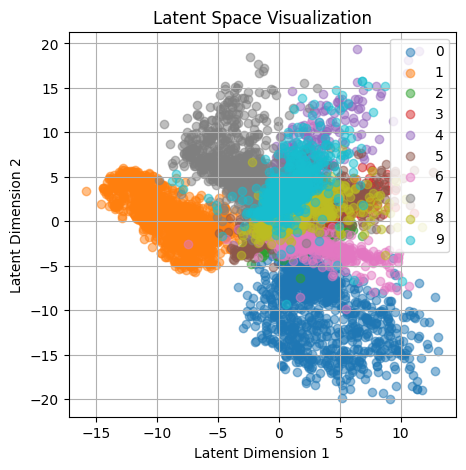

In [6]:

AE_model.eval()

# Calculate Latents out of test dataset
latents = []
labels = []

with torch.no_grad():
    for data, target in test_loader:
        if use_cuda: 
            data = data.cuda()
        _, _, z = AE_model(data)
        latents.append(z.detach().cpu())
        labels.append(target)

latents = torch.cat(latents).numpy()
labels = torch.cat(labels).numpy()

# Visualize these latents in a simple plot
plt.figure(figsize=(5, 5))
for i in range(10):
    idxs = labels == i
    plt.scatter(latents[idxs, 0], latents[idxs, 1], label=str(i), alpha=0.5)

plt.legend()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.grid(True)
plt.show()

With a VAE (Variational Auto Encoder), we restrict the latent to follow a Gaussian distribution.
After training, we can sample random points of the Gaussian latent and use the decoder to generate new images. 

To do so, we need to make some adjustments to the AE. 
To not write everything from scratch again, we use object-orientated programming.

For the VAE, we need to add a parametrisation and sampling function and rewrite the loss_function and forward function. 

To restrict the latent to a Gaussian, we use the latent to predict the mean and logarithmic variance (for stability reasons) of a Gaussian.
We then, during training, use the sampling function to sample a random point using the predicted mean and variance. 
The sampled value is then decoded by the decoder for the output image. 

Because we can not train this with the MSE loss anymore, we make use of the KL-divergence (for information, read <a href="https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73">here</a>). 
Therefore, adjust the loss function to follow: 
 $$ KL(N(\mu, \sigma), N(0, 1)) + MSE_{Loss} = 0.5 * \frac{\sum ( \mu^2 + \sigma - \log \sigma - 1)}{\textrm{Num. samples}} + 0.5 * \sum (\textrm{Input} - \textrm{Prediction})^2 $$

In [7]:

class VAE(Vanilla_AE):
    '''
    Implementation of a Simple VAE
    -----------------------------
    in_channels: Number of input Channels (in our case number of image Channels)
    latent_dim: determines the size of the latent dimension
    input_size: np.array of H x W of input images 
    hidden_dim: List of channel sizes of the Encoder Decoder layers
    
    '''

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 input_size: np.ndarray,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super().__init__(in_channels, latent_dim, input_size, hidden_dims)

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        # TODO: Implement the forward of the encode
        # This should return the predicted mu and log_var (use self.fc_mu and self.fc_var for this)
        # in the exact order given below
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        # TODO: Implement forward with reparametrization in it
        # Return in exact order given

        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      prediction: List[Tensor],
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        prediction: [recons, input, mu, log_var]
        
        REMEMBER: You predict the log(sigma) not sigma
        """
        # TODO: Implement Loss as discribed above
        recons, input, mu, log_var = prediction
        mse_loss = 0.5 * F.mse_loss(recons, input, reduction='sum') / mu.size(0)
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / mu.size(0)
        loss = mse_loss + kld_loss
        return loss

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input latent z, returns the reconstructed image
        :param z: (Tensor) [B x latent_dim]
        :return: (Tensor) [B x C x H x W]
        """
        # Function used to generate samples out of a given latent

        return self.decode(x)[0]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
       BatchNorm2d-2           [-1, 32, 14, 14]              64
         LeakyReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          18,496
       BatchNorm2d-5             [-1, 64, 7, 7]             128
         LeakyReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 2, 2]         295,168
      BatchNorm2d-11            [-1, 256, 2, 2]             512
        LeakyReLU-12            [-1, 256, 2, 2]               0
           Linear-13                    [-1, 2]           2,050
           Linear-14                   

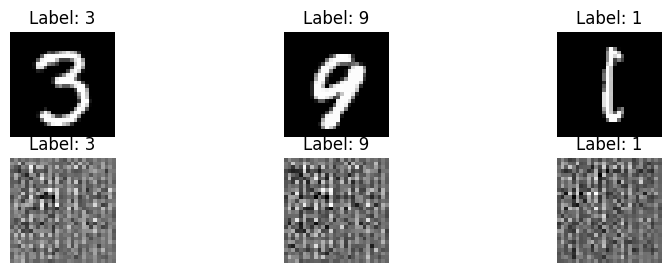

In [8]:
# Test your implementation
# You should see the original MNIST images and 2 noisy images below (since the AE is not trained yet)

VAE_model = VAE(in_channels=1, latent_dim=2, input_size=np.array([28, 28]), hidden_dims=[32, 64, 128, 256])

summary(VAE_model, input_size=(1, 28, 28), device='cpu')

data_instance = iter(train_loader)
images, labels = next(data_instance)

predicted_img, input, mu, log_var = VAE_model(images)

fig, axes = plt.subplots(2, 3, figsize=(10, 3))
for i in range(3):
    image = images[i].numpy().squeeze()  # Bild in numpy-Array umwandeln und Kanal dimension entfernen
    axes[0][i].imshow(image, cmap='gray')
    axes[0][i].set_title(f'Label: {labels[i].item()}')
    axes[0][i].axis('off')
    # Same for prediction
    pred_img = predicted_img[i].detach().numpy().squeeze()
    axes[1][i].imshow(pred_img, cmap='gray')
    axes[1][i].set_title(f'Label: {labels[i].item()}')
    axes[1][i].axis('off')
plt.show()


Test set: Average loss: 0.40668425

Train Epoch: 1 [0/60000 (0%)]	Loss: 390.08593750
Train Epoch: 1 [16000/60000 (27%)]	Loss: 227.28088379
Train Epoch: 1 [32000/60000 (53%)]	Loss: 223.32196045
Train Epoch: 1 [48000/60000 (80%)]	Loss: 203.08969116
Train Epoch: 1 	 Average: 3.62685074

Test set: Average loss: 0.22665244

Train Epoch: 2 [0/60000 (0%)]	Loss: 208.56488037
Train Epoch: 2 [16000/60000 (27%)]	Loss: 209.09384155
Train Epoch: 2 [32000/60000 (53%)]	Loss: 236.29307556
Train Epoch: 2 [48000/60000 (80%)]	Loss: 221.38531494
Train Epoch: 2 	 Average: 3.42168124

Test set: Average loss: 0.21991534

Train Epoch: 3 [0/60000 (0%)]	Loss: 208.37133789
Train Epoch: 3 [16000/60000 (27%)]	Loss: 218.99040222
Train Epoch: 3 [32000/60000 (53%)]	Loss: 219.03192139
Train Epoch: 3 [48000/60000 (80%)]	Loss: 206.79763794
Train Epoch: 3 	 Average: 3.35084479

Test set: Average loss: 0.21724206

Train Epoch: 4 [0/60000 (0%)]	Loss: 194.72619629
Train Epoch: 4 [16000/60000 (27%)]	Loss: 209.00054932
Train

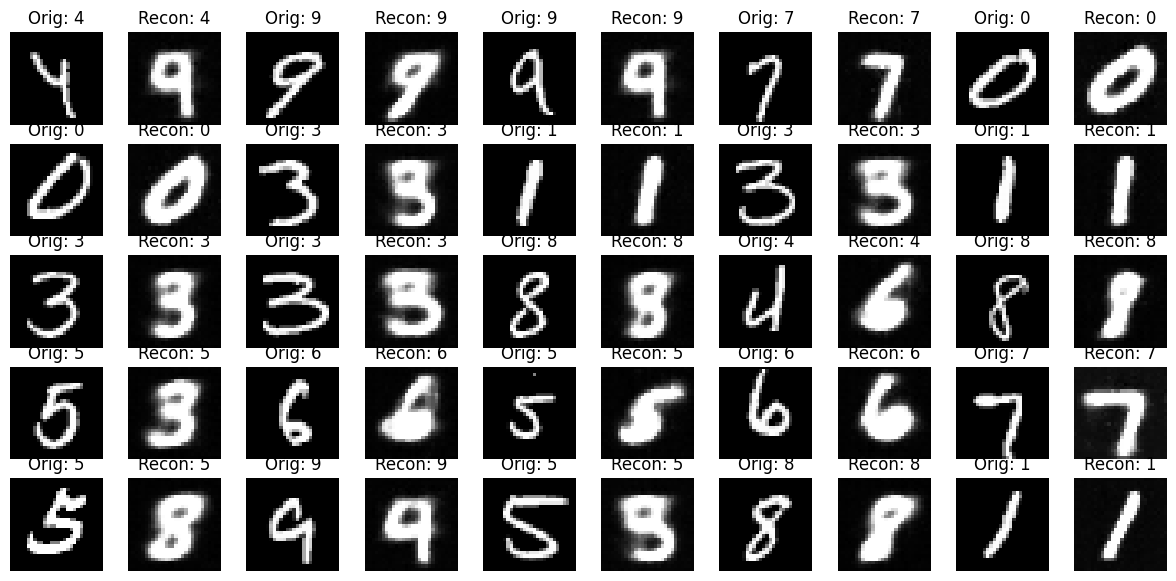

Train Epoch: 5 [0/60000 (0%)]	Loss: 201.23577881
Train Epoch: 5 [16000/60000 (27%)]	Loss: 213.28115845
Train Epoch: 5 [32000/60000 (53%)]	Loss: 206.52450562
Train Epoch: 5 [48000/60000 (80%)]	Loss: 212.31692505
Train Epoch: 5 	 Average: 3.27702446

Test set: Average loss: 0.21371273

Train Epoch: 6 [0/60000 (0%)]	Loss: 218.95332336
Train Epoch: 6 [16000/60000 (27%)]	Loss: 212.42030334
Train Epoch: 6 [32000/60000 (53%)]	Loss: 206.27087402
Train Epoch: 6 [48000/60000 (80%)]	Loss: 202.30117798
Train Epoch: 6 	 Average: 3.25539240

Test set: Average loss: 0.21150000

Train Epoch: 7 [0/60000 (0%)]	Loss: 214.76777649
Train Epoch: 7 [16000/60000 (27%)]	Loss: 193.49324036
Train Epoch: 7 [32000/60000 (53%)]	Loss: 198.53773499
Train Epoch: 7 [48000/60000 (80%)]	Loss: 228.68438721
Train Epoch: 7 	 Average: 3.23709621


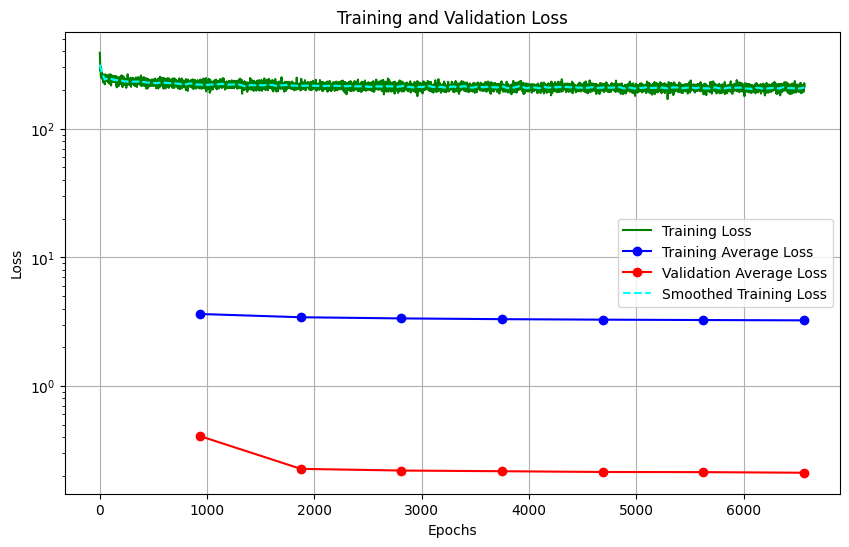

In [9]:
# Trainig 
epochs = 7
lr = 0.3
log_interval = 250

optimizer = optim.Adadelta(VAE_model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)


tr_loss = []
tr_loss_step = []
test_loss = []
if use_cuda: 
    VAE_model = VAE_model.cuda()
for epoch in range(1, epochs + 1):
    # Validate 
    if epoch % 5 == 0:
        validate(model=VAE_model, use_cuda=use_cuda, test_loader=test_loader, test_loss=test_loss, plot=True)
    else:
        validate(model=VAE_model, use_cuda=use_cuda, test_loader=test_loader, test_loss=test_loss, plot=False)
    # train one epoch
    train_loss_tmp = []
    train(model=VAE_model, use_cuda=use_cuda, train_loader=train_loader, optimizer=optimizer,
          epoch=epoch, log_interval=log_interval, tr_loss=train_loss_tmp)
    
    for i in range(len(train_loss_tmp)):
        tr_loss_step.append(train_loss_tmp[i])
    tr_loss.append(np.sum(train_loss_tmp).item() / len(train_loader.dataset))
    print(f'Train Epoch: {epoch} \t Average: {tr_loss[-1]:.8f}')

    scheduler.step(test_loss[-1])

plot_training(tr_loss_step, tr_loss, test_loss, epochs, train_loader, batch_size)

    

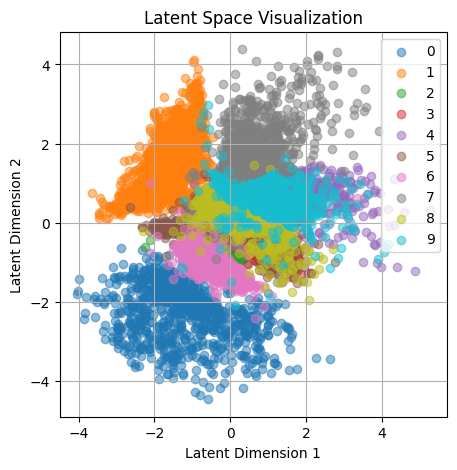

In [10]:

VAE_model.eval()

# Calculate Latents out of test dataset
latents = []
labels = []

with torch.no_grad():
    for data, target in test_loader:
        if use_cuda: 
            data = data.cuda()
        _, _, z, _ = VAE_model(data)
        latents.append(z.detach().cpu())
        labels.append(target)

latents = torch.cat(latents).numpy()
labels = torch.cat(labels).numpy()

# Visualize these latents in a simple plot
plt.figure(figsize=(5, 5))
for i in range(10):
    idxs = labels == i
    plt.scatter(latents[idxs, 0], latents[idxs, 1], label=str(i), alpha=0.5)

plt.legend()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.grid(True)
plt.show()



With this, your Data should look much more structured (much more centred around (0, 0), and clusters closer together).
Depending on your training time, this will get better with more epochs.

## 03 Visualize generated images (2P)

You are now asked to implement a grid over the latent space in the image above. 
Forward each point of the grid through the VAE and show the image.
The result should be an image consisting of multiple generated images. 
This is another visualisation of the Latent space. 


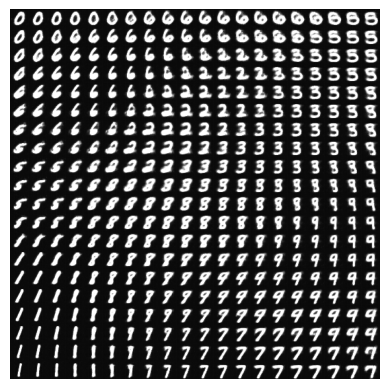

In [11]:
from scipy.stats import norm

n = 20 # amount of figure images
digit_size = 28
figure = np.zeros( (digit_size * n, digit_size * n) )

# TODO: Set up grid
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# Get the decodings 
# TODO: Get the decoded images and fill them into the figure-array
# Plot the resulting image

# Generate images from the grid points
VAE_model.eval()
with torch.no_grad():
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = torch.tensor([[xi, yi]]).float()
            z_sample = z_sample.to('cuda' if use_cuda else 'cpu')
            x_decoded = VAE_model.decode(z_sample)
            image = x_decoded.view(digit_size, digit_size).cpu().numpy()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = image

plt.imshow(figure, cmap='gray')
plt.axis('off')
plt.show()
